In [65]:
import pandas as pd

data_with_summaries = pd.read_parquet('../data/processed/structured_dataset_with_discharge_summaries.train.parquet')

In [66]:
data_with_summaries.shape

(1046, 27)

In [67]:
data_with_summaries['subject_id'].unique()

array([17504528, 14273001, 11357031, ..., 15711279, 18693941, 13688534],
      shape=(1034,))

In [68]:
data_with_summaries.head(10)

,subject_id,hadm_id,admittime,dischtime,admission_type,discharge_location,gender,dod,age_at_admit,length_of_stay_days,...,procedures_icd10,num_procedures_total,meds_discharge_like,medication_count,policy,discharge_summary,diagnosis_codes,model,true_icd_codes,missing_codes
0,17504528,20171885,2137-06-17 20:40:00,2137-06-20 16:41:00,DIRECT EMER.,HOME,F,2142-07-24,56,2.834028,...,[0W9B30Z],1.0,"[5% Dextrose, Albuterol 0.083% Neb Soln, Aspir...",24.0,partial,"**Discharge Summary** \n**Patient:** Female, ...","[E118, Z5181, I5032, K219, D473, I10, I071, M8...",gpt-4o-mini,"[I5032, E118, I10, E785, I2510, I071, D649, I2...","[Z7901, I272, E039, D72829, F419, E785, J45909..."
1,14273001,20371042,2187-10-19 19:00:00,2187-10-21 18:13:00,OBSERVATION ADMIT,HOME,F,2188-03-27,73,1.967361,...,None,NaN,"[Acetaminophen, Aspirin, Atorvastatin, Bisacod...",19.0,all,**Discharge Summary** \n**Patient:** 73-year-...,"[Z7901, Z87891, E039, Y929, I5031, E785, K219,...",gpt-4o-mini,"[I5031, I82501, C7931, C3431, E039, Z7901, I10...",[]
2,11357031,27612249,2139-01-17 21:04:00,2139-01-22 18:00:00,OBSERVATION ADMIT,HOME HEALTH CARE,M,2144-10-28,58,4.872222,...,None,NaN,"[0.9% Sodium Chloride (Mini Bag Plus), Amoxici...",30.0,primary_only,Discharge Summary: \n\nPatient is a 58-year-ol...,[I5033],gpt-4o-mini,"[I5033, J9692, J9691, E870, E872, E662, J441, ...","[E1140, I272, E872, I129, Z6833, E11319, E662,..."
3,13673554,25741865,2176-02-25 19:39:00,2176-03-02 17:30:00,OBSERVATION ADMIT,HOME HEALTH CARE,M,2180-11-21,71,5.910417,...,[0W993ZX],1.0,"[Acetaminophen, Aspirin, Atorvastatin, Cepacol...",17.0,partial,**Patient Discharge Summary** \n**Patient Nam...,"[I129, N184, I5033, N179, Z951, C9110, E780, I...",gpt-4o-mini,"[I5033, C9110, J918, N184, N179, I129, I2510, ...",[]
4,19017808,20589756,2183-01-05 21:59:00,2183-01-08 18:35:00,OBSERVATION ADMIT,HOME HEALTH CARE,F,2184-11-16,77,2.858333,...,None,NaN,"[0.9% Sodium Chloride (Mini Bag Plus), Acetami...",25.0,partial,**Discharge Summary** \n**Patient Information...,"[N2889, K7460, I8510, I5032, I4891, N179, I878...",gpt-4o-mini,"[I5032, I8510, N179, I272, K7460, N390, I4891,...","[I272, Y929, S5001XA, W19XXXA, I10, Z85038, K7..."
5,19973083,20741363,2123-10-12 04:00:00,2123-10-20 16:35:00,OBSERVATION ADMIT,HOME HEALTH CARE,F,NaT,58,8.524306,...,None,NaN,"[Acetaminophen, Amiodarone, Aspirin EC, Atorva...",12.0,primary_only,"**Discharge Summary** \n**Patient:** Female, ...",[I5033],gpt-4o-mini,"[I5033, N170, J9691, D6861, I4892, I340, Z7901...","[R351, Z90710, I361, D6861, I340, I10, I2720, ..."
6,14541392,25068197,2124-09-02 00:07:00,2124-09-03 15:36:00,EW EMER.,HOME,M,2125-10-01,58,1.645139,...,None,NaN,"[Acetaminophen, Albuterol 0.083% Neb Soln, Bis...",25.0,primary_only,Patient is a 58-year-old male admitted via eme...,[I5033],gpt-4o-mini,"[I5033, G92, J441, I8510, Z6842, F17210, K7469...","[K7469, T473X6A, K7290, K7030, Z91128, F1190, ..."
7,10320090,26774424,2178-04-05 00:00:00,2178-04-12 15:46:00,URGENT,HOME,M,2179-05-25,33,7.656944,...,None,NaN,"[5% Dextrose, Acetaminophen, Amiodarone, Clobe...",17.0,primary_only,"**Patient Information:** 33-year-old male, adm...",[I5023],gpt-4o-mini,"[I5023, I429, N179, Z6843, E669, I480, D638, L...","[M25569, D638, I340, N179, Z7982, I429, Z23, E..."
8,10906285,29225762,2179-09-17 17:46:00,2179-09-23 16:12:00,OBSERVATION ADMIT,HOME HEALTH CARE,M,NaT,70,5.934722,...,None,NaN,"[Acetaminophen, Atorvastatin, BuPROPion XL (On...",16.0,partial,**Patient Information:** 70-year-old male admi...,"[Z7901, Z87891, I428, D539, K219, I5033, Z6837...",gpt-4o-mini,"[I5033, C8510, I428, N400, F32A, K219, I2584, ...","[E669, F32A, R3121, J449, Z20822, C8510, N400,..."
9,15559495,21036461,2116-08-10 22:43:00,2116-08-28 15:37:00,OBSERVATION ADMIT,HOME HEALTH CARE,F,NaT,78,17.704167,...,"[5A2204Z, 0DJ08ZZ, B24BZZ4]",3.0,"[Acetaminophen, Apixaban, Bisacodyl, Bumetanid...",16.0,all,**Discharge Summary** \n**Patient:** 78-year-...,"[Z7901, Y929, I081, Y838, I5021, T84092A, R090...",gpt

In [7]:
data_with_summaries.columns


Index(['subject_id', 'hadm_id', 'admittime', 'dischtime', 'admission_type',
       'discharge_location', 'gender', 'dod', 'age_at_admit',
       'length_of_stay_days', 'icd10_codes', 'icd10_descriptions',
       'num_icd10_codes', 'primary_icd10', 'icd_version', 'primary_icd10_desc',
       'primary_pdgm_bucket_simple', 'procedures_icd10',
       'num_procedures_total', 'meds_discharge_like', 'medication_count',
       'policy', 'discharge_summary', 'diagnosis_codes', 'model',
       'true_icd_codes', 'missing_codes'],
      dtype='object')

## 2. Medical NER Setup

We'll use several state-of-the-art medical NER models:
1. **scispaCy**: Specialized for scientific and biomedical text
2. **Hugging Face Transformers**: Clinical BERT, BioBERT models
3. **MedCAT**: Medical Concept Annotation Tool

Key entity types to extract:
- **Diseases/Conditions**: Diagnoses, symptoms
- **Medications**: Drug names, dosages
- **Procedures**: Medical tests, treatments
- **Anatomy**: Body parts, organs
- **Lab Values**: Test results, measurements


### 2.1 Install Required Libraries

Run this cell once to install the necessary packages:


In [13]:
# Installation commands (uncomment to run)
# !pip install scispacy
# !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.4/en_core_sci_sm-0.5.4.tar.gz
# !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.4/en_ner_bc5cdr_md-0.5.4.tar.gz
!uv pip install transformers torch
# !pip install medcat
!uv pip install scikit-learn matplotlib seaborn
!uv pip install datasets

print("To install required packages, uncomment and run the above commands")


Resolved 24 packages in 217ms                                        
⠙ Preparing packages... (0/6)                                                   
⠙ Preparing packages... (0/6)--------------     0 B/131.74 KiB          
⠙ Preparing packages... (0/6)-------------- 16.00 KiB/131.74 KiB        
⠙ Preparing packages... (0/6)-------------- 16.00 KiB/131.74 KiB        
jinja2               ------------------------------ 16.00 KiB/131.74 KiB
⠙ Preparing packages... (0/6)--------------     0 B/1.64 MiB            
jinja2               ------------------------------ 16.00 KiB/131.74 KiB
⠙ Preparing packages... (0/6)-------------- 14.88 KiB/1.64 MiB          
jinja2               ------------------------------ 32.00 KiB/131.74 KiB
⠙ Preparing packages... (0/6)-------------- 14.88 KiB/1.64 MiB          
jinja2               ------------------------------ 48.00 KiB/131.74 KiB
⠙ Preparing packages... (0/6)-------------- 14.88 KiB/1.64 MiB          
jinja2               -------------------------

In [69]:
# Use a pipeline as a high-level helper
from transformers import pipeline

disease_ner = pipeline("token-classification", model="OpenMed/OpenMed-NER-DiseaseDetect-SuperClinical-184M")

Device set to use mps:0


In [ ]:
# import os
# os.environ["HF_HUB_DISABLE_PROGRESS_BARS"] = "1"

In [33]:
from transformers import pipeline
drug_ner = pipeline('token-classification', model = "OpenMed/OpenMed-NER-PharmaDetect-ModernClinical-149M")
# anatomy_ner = pipeline('token-classification', model = "OpenMed/OpenMed-NER-AnatomyDetect-ElectraMed-109M")

Device set to use mps:0


In [42]:

anatomy_ner = pipeline('token-classification', model = "OpenMed/OpenMed-NER-AnatomyDetect-ElectraMed-109M")

Device set to use mps:0


In [8]:
sample_texts = data_with_summaries['discharge_summary'].values[:4]

In [9]:
sample_texts

array(["**Discharge Summary**  \n**Patient:** Female, 56 years  \n**Admission Type:** Direct Emergency  \n**Length of Stay:** 2.8 days  \n**Primary Diagnosis:** Chronic diastolic (congestive) heart failure (ICD-10: I5032)  \n  \n**History of Present Illness:**  \nThe patient was admitted following an acute exacerbation of chronic diastolic heart failure. She presented with shortness of breath, lower extremity edema, and fatigue. Her medical history is significant for type 2 diabetes mellitus, hypertension, hyperlipidemia, and atherosclerotic heart disease.  \n  \n**Hospital Course:**  \nDuring her hospitalization, the patient's heart failure was managed with diuretics and fluid restriction, leading to a significant reduction in her symptoms. She was started on a regimen of medications including Enoxaparin, Aspirin, and Levothyroxine, among others. The patient's diabetes and hypertension were also optimized during her stay. Multiple disciplines including cardiology and nutrition were in

In [13]:
output = disease_ner(sample_texts[0])

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [34]:
drug_output = drug_ner(sample_texts[0])

In [43]:
anatomy_output = anatomy_ner(sample_texts[0])

In [44]:
anatomy_output

[{'entity': 'B-Anatomy',
  'score': np.float32(0.9333687),
  'index': 54,
  'word': 'heart',
  'start': 180,
  'end': 185},
 {'entity': 'B-Anatomy',
  'score': np.float32(0.89404994),
  'index': 91,
  'word': 'heart',
  'start': 327,
  'end': 332},
 {'entity': 'I-Anatomy',
  'score': np.float32(0.45976025),
  'index': 106,
  'word': 'ed',
  'start': 398,
  'end': 400},
 {'entity': 'B-Anatomy',
  'score': np.float32(0.6807671),
  'index': 107,
  'word': '##ema',
  'start': 400,
  'end': 403},
 {'entity': 'B-Anatomy',
  'score': np.float32(0.7906781),
  'index': 140,
  'word': 'heart',
  'start': 533,
  'end': 538},
 {'entity': 'B-Anatomy',
  'score': np.float32(0.72730625),
  'index': 159,
  'word': 'heart',
  'start': 618,
  'end': 623},
 {'entity': 'B-Anatomy',
  'score': np.float32(0.92283326),
  'index': 254,
  'word': 'left',
  'start': 1076,
  'end': 1080},
 {'entity': 'I-Anatomy',
  'score': np.float32(0.95829153),
  'index': 255,
  'word': 'vent',
  'start': 1081,
  'end': 1085}

In [35]:
print(drug_output)

[{'entity': 'B-CHEM', 'score': np.float32(0.9542466), 'index': 171, 'word': 'ĠEn', 'start': 787, 'end': 790}, {'entity': 'B-CHEM', 'score': np.float32(0.9353572), 'index': 172, 'word': 'ox', 'start': 790, 'end': 792}, {'entity': 'B-CHEM', 'score': np.float32(0.9605775), 'index': 173, 'word': 'ap', 'start': 792, 'end': 794}, {'entity': 'B-CHEM', 'score': np.float32(0.9393676), 'index': 174, 'word': 'arin', 'start': 794, 'end': 798}, {'entity': 'B-CHEM', 'score': np.float32(0.9601156), 'index': 176, 'word': 'ĠAsp', 'start': 799, 'end': 803}, {'entity': 'B-CHEM', 'score': np.float32(0.9410289), 'index': 177, 'word': 'ir', 'start': 803, 'end': 805}, {'entity': 'B-CHEM', 'score': np.float32(0.9295902), 'index': 178, 'word': 'in', 'start': 805, 'end': 807}, {'entity': 'B-CHEM', 'score': np.float32(0.96151996), 'index': 181, 'word': 'ĠLev', 'start': 812, 'end': 816}, {'entity': 'B-CHEM', 'score': np.float32(0.9356838), 'index': 182, 'word': 'othy', 'start': 816, 'end': 820}, {'entity': 'B-CHE

In [32]:
# Test NER on sample clinical text


print("Sample NER Results:")
print("="*80)

for i, text in enumerate(sample_texts[:3], 1):
    if pd.notna(text) and len(str(text)) > 10:
        try:
            
            # entities = disease_ner(text)
            drug_ents = drug_ner(text)
            # print(f"\n{i}. Text: {str(text)[:100]}...")
            # print(f"   Entities found:")
            # if entities:
            #     for ent in entities:
            #         # Pipeline returns dict with 'word', 'entity_group', 'score', etc.
            #         entity_text = ent['word']
            #         entity_type = ent['entity_group']
            #         confidence = ent['score']
            #         print(f"   - {entity_text:30s} | {entity_type:15s} | Score: {confidence:.3f}")
            # else:
            #     print("   - No entities detected")

            if drug_ents:
                for ent in drug_ents:
                    # Pipeline returns dict with 'word', 'entity_group', 'score', etc.
                    entity_text = ent['word']
                    entity_type = ent['entity_group']
                    confidence = ent['score']
                    print(f"   - {entity_text:30s} | {entity_type:15s} | Score: {confidence:.3f}")
                
        except Exception as e:
            print(f"Error processing text: {e}")
            continue


Sample NER Results:
   -  En                            | CHEM            | Score: 0.954
   - ox                             | CHEM            | Score: 0.935
   - ap                             | CHEM            | Score: 0.961
   - arin                           | CHEM            | Score: 0.939
   -  Asp                           | CHEM            | Score: 0.960
   - ir                             | CHEM            | Score: 0.941
   - in                             | CHEM            | Score: 0.930
   -  Lev                           | CHEM            | Score: 0.962
   - othy                           | CHEM            | Score: 0.936
   - rox                            | CHEM            | Score: 0.932
   - ine                            | CHEM            | Score: 0.936
   -  glucose                       | CHEM            | Score: 0.583
   -  5                             | CHEM            | Score: 0.498
   -  De                            | CHEM            | Score: 0.540
   - xt       

In [ ]:
# import re
# def smart_group_entities(tokens, text):
#   """
#   Smart entity grouping that properly merges sub-tokens into complete entities.
#   This fixes the issue where aggregation_strategy="simple" creates overlapping spans.
#   """
#   if not tokens:
#       return []

#   entities = []
#   current_entity = None

#   for token in tokens:
#       label = token['entity']
#       score = token['score']
#       word = token['word']
#       start = token['start']
#       end = token['end']

#       # Skip O (Outside) tags
#       if label == 'O':
#           if current_entity:
#               entities.append(current_entity)
#               current_entity = None
#           continue

#       # Clean the label (remove B- and I- prefixes)
#       clean_label = label.replace('B-', '').replace('I-', '')

#       # Start new entity (B- tag or different entity type)
#       if label.startswith('B-') or (current_entity and current_entity['entity_group'] != clean_label):
#           if current_entity:
#               entities.append(current_entity)

#           current_entity = {
#               'entity_group': clean_label,
#               'score': score,
#               'word': text[start:end],  # Use actual text from the source
#               'start': start,
#               'end': end
#           }

#       # Continue current entity (I- tag)
#       elif current_entity and clean_label == current_entity['entity_group']:
#           # Extend the current entity
#           current_entity['end'] = end
#           current_entity['word'] = text[current_entity['start']:end]
#           current_entity['score'] = (current_entity['score'] + score) / 2  # Average scores

#   # Don't forget the last entity
#   if current_entity:
#       entities.append(current_entity)

#   return entities

def filter_and_group_entities(tokens, text, confidence_threshold=0.6):

  # Use our smart grouping to merge sub-tokens into complete entities
  grouped_entities = smart_group_entities(tokens, text)
#   print(f"Smart grouping created {len(grouped_entities)} entities")

  # Apply confidence filtering to the grouped entities
  filtered_entities = []
  for entity in grouped_entities:
    if entity["score"] >= confidence_threshold:
        # Apply additional quality filters
        if (len(entity["word"].strip()) > 0 and  # Not empty
            re.search(r"[A-Za-z0-9]", entity["word"])):  # Contains actual content
            filtered_entities.append(entity)
  return filtered_entities

  

In [41]:
def smart_group_entities(tokens, text):
  """
  Merge subword pieces into full entities using offsets and tokenizer clues.
  Works with RoBERTa (Ġ), SentencePiece (▁), and WordPiece (##).
  """
  if not tokens:
    return []

  entities = []
  current = None

  for t in tokens:
    label = t['entity']
    base = label.replace('B-', '').replace('I-', '')
    start, end = t['start'], t['end']
    word = t['word']

    starts_new_word = word.startswith('Ġ') or word.startswith('▁')
    is_wordpiece_cont = word.startswith('##')

    should_continue = (
      current is not None and
      current['entity_group'] == base and
      (
        label.startswith('I-') or
        ((not starts_new_word or is_wordpiece_cont) and start <= current['end'] + 1)
      )
    )

    if should_continue:
      # length-weighted score update
      prev_len = current['end'] - current['start']
      this_len = end - start
      total_len = prev_len + this_len
      current['score'] = (current['score'] * prev_len + t['score'] * this_len) / max(total_len, 1)
      current['end'] = end
      current['word'] = text[current['start']:current['end']]
    else:
      if current:
        entities.append(current)
      current = {
        'entity_group': base,
        'score': t['score'],
        'word': text[start:end],
        'start': start,
        'end': end
      }

  if current:
    entities.append(current)

  return entities

def filter_and_group_entities(tokens, text, confidence_threshold=0.6):

  # Use our smart grouping to merge sub-tokens into complete entities
  grouped_entities = smart_group_entities(tokens, text)
#   print(f"Smart grouping created {len(grouped_entities)} entities")

  # Apply confidence filtering to the grouped entities
  filtered_entities = []
  for entity in grouped_entities:
    if entity["score"] >= confidence_threshold:
        # Apply additional quality filters
        if (len(entity["word"].strip()) > 0 and  # Not empty
            re.search(r"[A-Za-z0-9]", entity["word"])):  # Contains actual content
            filtered_entities.append(entity)
  return filtered_entities


In [23]:
print(sample_texts[0])

**Discharge Summary**  
**Patient:** Female, 56 years  
**Admission Type:** Direct Emergency  
**Length of Stay:** 2.8 days  
**Primary Diagnosis:** Chronic diastolic (congestive) heart failure (ICD-10: I5032)  
  
**History of Present Illness:**  
The patient was admitted following an acute exacerbation of chronic diastolic heart failure. She presented with shortness of breath, lower extremity edema, and fatigue. Her medical history is significant for type 2 diabetes mellitus, hypertension, hyperlipidemia, and atherosclerotic heart disease.  
  
**Hospital Course:**  
During her hospitalization, the patient's heart failure was managed with diuretics and fluid restriction, leading to a significant reduction in her symptoms. She was started on a regimen of medications including Enoxaparin, Aspirin, and Levothyroxine, among others. The patient's diabetes and hypertension were also optimized during her stay. Multiple disciplines including cardiology and nutrition were involved in her care

In [37]:
drug_output

[{'entity': 'B-CHEM',
  'score': np.float32(0.9542466),
  'index': 171,
  'word': 'ĠEn',
  'start': 787,
  'end': 790},
 {'entity': 'B-CHEM',
  'score': np.float32(0.9353572),
  'index': 172,
  'word': 'ox',
  'start': 790,
  'end': 792},
 {'entity': 'B-CHEM',
  'score': np.float32(0.9605775),
  'index': 173,
  'word': 'ap',
  'start': 792,
  'end': 794},
 {'entity': 'B-CHEM',
  'score': np.float32(0.9393676),
  'index': 174,
  'word': 'arin',
  'start': 794,
  'end': 798},
 {'entity': 'B-CHEM',
  'score': np.float32(0.9601156),
  'index': 176,
  'word': 'ĠAsp',
  'start': 799,
  'end': 803},
 {'entity': 'B-CHEM',
  'score': np.float32(0.9410289),
  'index': 177,
  'word': 'ir',
  'start': 803,
  'end': 805},
 {'entity': 'B-CHEM',
  'score': np.float32(0.9295902),
  'index': 178,
  'word': 'in',
  'start': 805,
  'end': 807},
 {'entity': 'B-CHEM',
  'score': np.float32(0.96151996),
  'index': 181,
  'word': 'ĠLev',
  'start': 812,
  'end': 816},
 {'entity': 'B-CHEM',
  'score': np.floa

In [45]:
filter_and_group_entities(anatomy_output, sample_texts[0])

[{'entity_group': 'Anatomy',
  'score': np.float32(0.9333687),
  'word': 'heart',
  'start': 180,
  'end': 185},
 {'entity_group': 'Anatomy',
  'score': np.float32(0.76644605),
  'word': 'heart failure. She presented with shortness of breath, lower extremity edema',
  'start': 327,
  'end': 403},
 {'entity_group': 'Anatomy',
  'score': np.float32(0.7906781),
  'word': 'heart',
  'start': 533,
  'end': 538},
 {'entity_group': 'Anatomy',
  'score': np.float32(0.72730625),
  'word': 'heart',
  'start': 618,
  'end': 623},
 {'entity_group': 'Anatomy',
  'score': np.float32(0.9468587),
  'word': 'left ventricular',
  'start': 1076,
  'end': 1092},
 {'entity_group': 'Anatomy',
  'score': np.float32(0.8780797),
  'word': 'heart',
  'start': 1641,
  'end': 1646},
 {'entity_group': 'Anatomy',
  'score': np.float32(0.9158247),
  'word': 'heart',
  'start': 2167,
  'end': 2172}]

In [38]:
t = filter_and_group_entities(drug_output, sample_texts[0])

In [40]:
t

[{'entity_group': 'CHEM',
  'score': np.float32(0.9465527),
  'word': ' Enoxaparin',
  'start': 787,
  'end': 798},
 {'entity_group': 'CHEM',
  'score': np.float32(0.9477126),
  'word': ' Aspirin',
  'start': 799,
  'end': 807},
 {'entity_group': 'CHEM',
  'score': np.float32(0.94225377),
  'word': ' Levothyroxine',
  'start': 812,
  'end': 826},
 {'entity_group': 'CHEM',
  'score': np.float32(0.7027694),
  'word': ' Albuterol 0.083% Nebulizer Solution',
  'start': 1746,
  'end': 1782},
 {'entity_group': 'CHEM',
  'score': np.float32(0.9462945),
  'word': ' Aspirin',
  'start': 1787,
  'end': 1795},
 {'entity_group': 'CHEM',
  'score': np.float32(0.9519936),
  'word': ' Clonazepam',
  'start': 1800,
  'end': 1811},
 {'entity_group': 'CHEM',
  'score': np.float32(0.9325466),
  'word': ' Docusate Sodium',
  'start': 1816,
  'end': 1832},
 {'entity_group': 'CHEM',
  'score': np.float32(0.96037877),
  'word': ' Enoxaparin Sodium',
  'start': 1837,
  'end': 1855},
 {'entity_group': 'CHEM',


In [39]:
sorted(t, key = lambda x: x['start'])

[{'entity_group': 'CHEM',
  'score': np.float32(0.9465527),
  'word': ' Enoxaparin',
  'start': 787,
  'end': 798},
 {'entity_group': 'CHEM',
  'score': np.float32(0.9477126),
  'word': ' Aspirin',
  'start': 799,
  'end': 807},
 {'entity_group': 'CHEM',
  'score': np.float32(0.94225377),
  'word': ' Levothyroxine',
  'start': 812,
  'end': 826},
 {'entity_group': 'CHEM',
  'score': np.float32(0.7027694),
  'word': ' Albuterol 0.083% Nebulizer Solution',
  'start': 1746,
  'end': 1782},
 {'entity_group': 'CHEM',
  'score': np.float32(0.9462945),
  'word': ' Aspirin',
  'start': 1787,
  'end': 1795},
 {'entity_group': 'CHEM',
  'score': np.float32(0.9519936),
  'word': ' Clonazepam',
  'start': 1800,
  'end': 1811},
 {'entity_group': 'CHEM',
  'score': np.float32(0.9325466),
  'word': ' Docusate Sodium',
  'start': 1816,
  'end': 1832},
 {'entity_group': 'CHEM',
  'score': np.float32(0.96037877),
  'word': ' Enoxaparin Sodium',
  'start': 1837,
  'end': 1855},
 {'entity_group': 'CHEM',


### 2.3 Apply NER to Dataset

Create a function to extract entities from all text fields and create NER features.


In [ ]:
def extract_entities_from_text(text, nlp_model):
    """
    Extract named entities from text using the provided NER model.
    
    Returns:
        dict: Dictionary with entity counts by type and list of entity texts
    """
    if pd.isna(text) or str(text).strip() == '' or str(text) == '___':
        return {
            'count': 0,
            'entities': []
        }
    
    try:
        doc = nlp_model(text, batch_size = 8)  # Limit text length for efficiency
        entities = filter_and_group_entities(doc, text)

        ent_count = len(entities)
        
        return {
            'count': len(entities),
            'entities': entities
        }

    except Exception as e:
        print(e)
        raise e


In [49]:
list(data_sample['discharge_summary'].values)

["**Discharge Summary**  \n**Patient:** Female, 56 years  \n**Admission Type:** Direct Emergency  \n**Length of Stay:** 2.8 days  \n**Primary Diagnosis:** Chronic diastolic (congestive) heart failure (ICD-10: I5032)  \n  \n**History of Present Illness:**  \nThe patient was admitted following an acute exacerbation of chronic diastolic heart failure. She presented with shortness of breath, lower extremity edema, and fatigue. Her medical history is significant for type 2 diabetes mellitus, hypertension, hyperlipidemia, and atherosclerotic heart disease.  \n  \n**Hospital Course:**  \nDuring her hospitalization, the patient's heart failure was managed with diuretics and fluid restriction, leading to a significant reduction in her symptoms. She was started on a regimen of medications including Enoxaparin, Aspirin, and Levothyroxine, among others. The patient's diabetes and hypertension were also optimized during her stay. Multiple disciplines including cardiology and nutrition were involved

In [50]:
# Process a sample of the data (first 1000 records) to demonstrate NER feature extraction
print("Processing sample data with NER...")
print("This may take a few minutes...")

# sample_size = 1000
data_sample =  data_with_summaries.copy()

# # Combine relevant text fields into a single text for NER processing
# data_sample['combined_text'] = (
#     data_sample['comments'].fillna('') + ' ' + 
#     data_sample['drug'].fillna('') + ' ' +
#     data_sample['test_name'].fillna('') + ' ' +
#     data_sample['spec_type_desc'].fillna('')
# ).str.strip()

# Apply NER to combined text


disease_ner_results = disease_ner(list(data_sample['discharge_summary'].values), batch_size = 8)

drug_ner_results = drug_ner(list(data_sample['discharge_summary'].values), batch_size = 8)

anatomy_ner_results = anatomy_ner(list(data_sample['discharge_summary'].values), batch_size = 8)


# Extract NER features
# data_sample['disease_entity_count'] = disease_ner_results.apply(lambda x: x['count'])
# data_sample['drug_entity_count'] = drug_ner_results.apply(lambda x: x['count'])
# data_sample['anatomy_entity_count'] = anatomy_ner_results.apply(lambda x: x['count'])
# data_sample['disease_entities'] = disease_ner_results.apply(lambda x: x['entities'])
# data_sample['drug_entities'] = drug_ner_results.apply(lambda x: x['entities'])
# data_sample['anatomy_entities'] = anatomy_ner_results.apply(lambda x: x['entities'])



Processing sample data with NER...
This may take a few minutes...

✓ Processed 1046 records


KeyError: "None of [Index(['disease_entity_count', 'drug_entity_count', 'anatomy_entity_count'], dtype='object')] are in the [columns]"

In [52]:
processed_disease_ner_results = [filter_and_group_entities(doc, text) for doc, text in zip(disease_ner_results, list(data_sample['discharge_summary'].values))]
processed_drug_ner_results = [filter_and_group_entities(doc, text) for doc, text in zip(drug_ner_results, list(data_sample['discharge_summary'].values))]
processed_anatomy_ner_results = [filter_and_group_entities(doc, text) for doc, text in zip(anatomy_ner_results, list(data_sample['discharge_summary'].values))]


In [55]:
data_sample['disease_entity_count'] = [len(x) for x in processed_disease_ner_results]
data_sample['drug_entity_count'] = [len(x) for x in processed_drug_ner_results]
data_sample['anatomy_entity_count'] = [len(x) for x in processed_anatomy_ner_results]
data_sample['disease_entities'] = processed_disease_ner_results
data_sample['drug_entities'] = processed_drug_ner_results
data_sample['anatomy_entities'] = processed_anatomy_ner_results

In [60]:
print(f"\n✓ Processed {len(data_sample)} records")
print(f"Total entities extracted: {data_sample[['disease_entity_count', 'drug_entity_count', 'anatomy_entity_count']].sum(axis = 1).sum():,}")
print(f"Average entities per record: {data_sample[['disease_entity_count', 'drug_entity_count', 'anatomy_entity_count']].mean(axis = 1).mean():.2f}")


✓ Processed 1046 records
Total entities extracted: 32,172
Average entities per record: 10.25


In [61]:
data_sample.head()

,subject_id,hadm_id,admittime,dischtime,admission_type,discharge_location,gender,dod,age_at_admit,length_of_stay_days,...,diagnosis_codes,model,true_icd_codes,missing_codes,disease_entity_count,drug_entity_count,anatomy_entity_count,disease_entities,drug_entities,anatomy_entities
0,17504528,20171885,2137-06-17 20:40:00,2137-06-20 16:41:00,DIRECT EMER.,HOME,F,2142-07-24,56,2.834028,...,"[E118, Z5181, I5032, K219, D473, I10, I071, M8...",gpt-4o-mini,"[I5032, E118, I10, E785, I2510, I071, D649, I2...","[Z7901, I272, E039, D72829, F419, E785, J45909...",19,13,7,"[{'entity_group': 'DISEASE', 'score': 0.694758...","[{'entity_group': 'CHEM', 'score': 0.94702816,...","[{'entity_group': 'Anatomy', 'score': 0.933714..."
1,14273001,20371042,2187-10-19 19:00:00,2187-10-21 18:13:00,OBSERVATION ADMIT,HOME,F,2188-03-27,73,1.967361,...,"[Z7901, Z87891, E039, Y929, I5031, E785, K219,...",gpt-4o-mini,"[I5031, I82501, C7931, C3431, E039, Z7901, I10...",[],13,12,9,"[{'entity_group': 'DISEASE', 'score': 0.859448...","[{'entity_group': 'CHEM', 'score': 0.70878446,...","[{'entity_group': 'Anatomy', 'score': 0.856348..."
2,11357031,27612249,2139-01-17 21:04:00,2139-01-22 18:00:00,OBSERVATION ADMIT,HOME HEALTH CARE,M,2144-10-28,58,4.872222,...,[I5033],gpt-4o-mini,"[I5033, J9692, J9691, E870, E872, E662, J441, ...","[E1140, I272, E872, I129, Z6833, E11319, E662,...",12,9,8,"[{'entity_group': 'DISEASE', 'score': 0.955208...","[{'entity_group': 'CHEM', 'score': 0.9232956, ...","[{'entity_group': 'Anatomy', 'score': 0.748473..."
3,13673554,25741865,2176-02-25 19:39:00,2176-03-02 17:30:00,OBSERVATION ADMIT,HOME HEALTH CARE,M,2180-11-21,71,5.910417,...,"[I129, N184, I5033, N179, Z951, C9110, E780, I...",gpt-4o-mini,"[I5033, C9110, J918, N184, N179, I129, I2510, ...",[],15,9,12,"[{'entity_group': 'DISEASE', 'score': 0.959855...","[{'entity_group': 'CHEM', 'score': 0.9267071, ...","[{'entity_group': 'Anatomy', 'score': 0.735421..."
4,19017808,20589756,2183-01-05 21:59:00,2183-01-08 18:35:00,OBSERVATION ADMIT,HOME HEALTH CARE,F,2184-11-16,77,2.858333,...,"[N2889, K7460, I8510, I5032, I4891, N179, I878...",gpt-4o-mini,"[I5032, I8510, N179, I272, K7460, N390, I4891,...","[I272, Y929, S5001XA, W19XXXA, I10, Z85038, K7...",14,7,11,"[{'entity_group': 'DISEASE', 'score': 0.905572...","[{'entity_group': 'CHEM', 'score': 0.9423098, ...","[{'entity_group': 'Anatomy', 'score': 0.855203..."


In [72]:
data_sample.to_csv('../data/processed/structured_dataset_with_discharge_summaries_ner_features.train.csv', index = False)

In [23]:
data_sample['entities'][0]

[{'entity_group': 'DISEASE',
  'score': np.float32(0.87753165),
  'word': ' diastolic (congestive) heart failure',
  'start': 156,
  'end': 193},
 {'entity_group': 'DISEASE',
  'score': np.float32(0.95869887),
  'word': ' diastolic heart failure',
  'start': 316,
  'end': 340},
 {'entity_group': 'DISEASE',
  'score': np.float32(0.9269001),
  'word': ' shortness of breath',
  'start': 360,
  'end': 380},
 {'entity_group': 'DISEASE',
  'score': np.float32(0.62120926),
  'word': ' fatigue',
  'start': 408,
  'end': 416},
 {'entity_group': 'DISEASE',
  'score': np.float32(0.9464508),
  'word': ' type 2 diabetes mellitus',
  'start': 456,
  'end': 481},
 {'entity_group': 'DISEASE',
  'score': np.float32(0.8956117),
  'word': ' hypertension',
  'start': 482,
  'end': 495},
 {'entity_group': 'DISEASE',
  'score': np.float32(0.94288975),
  'word': ' hyper',
  'start': 496,
  'end': 502},
 {'entity_group': 'DISEASE',
  'score': np.float32(0.9335575),
  'word': 'lipid',
  'start': 502,
  'end': 

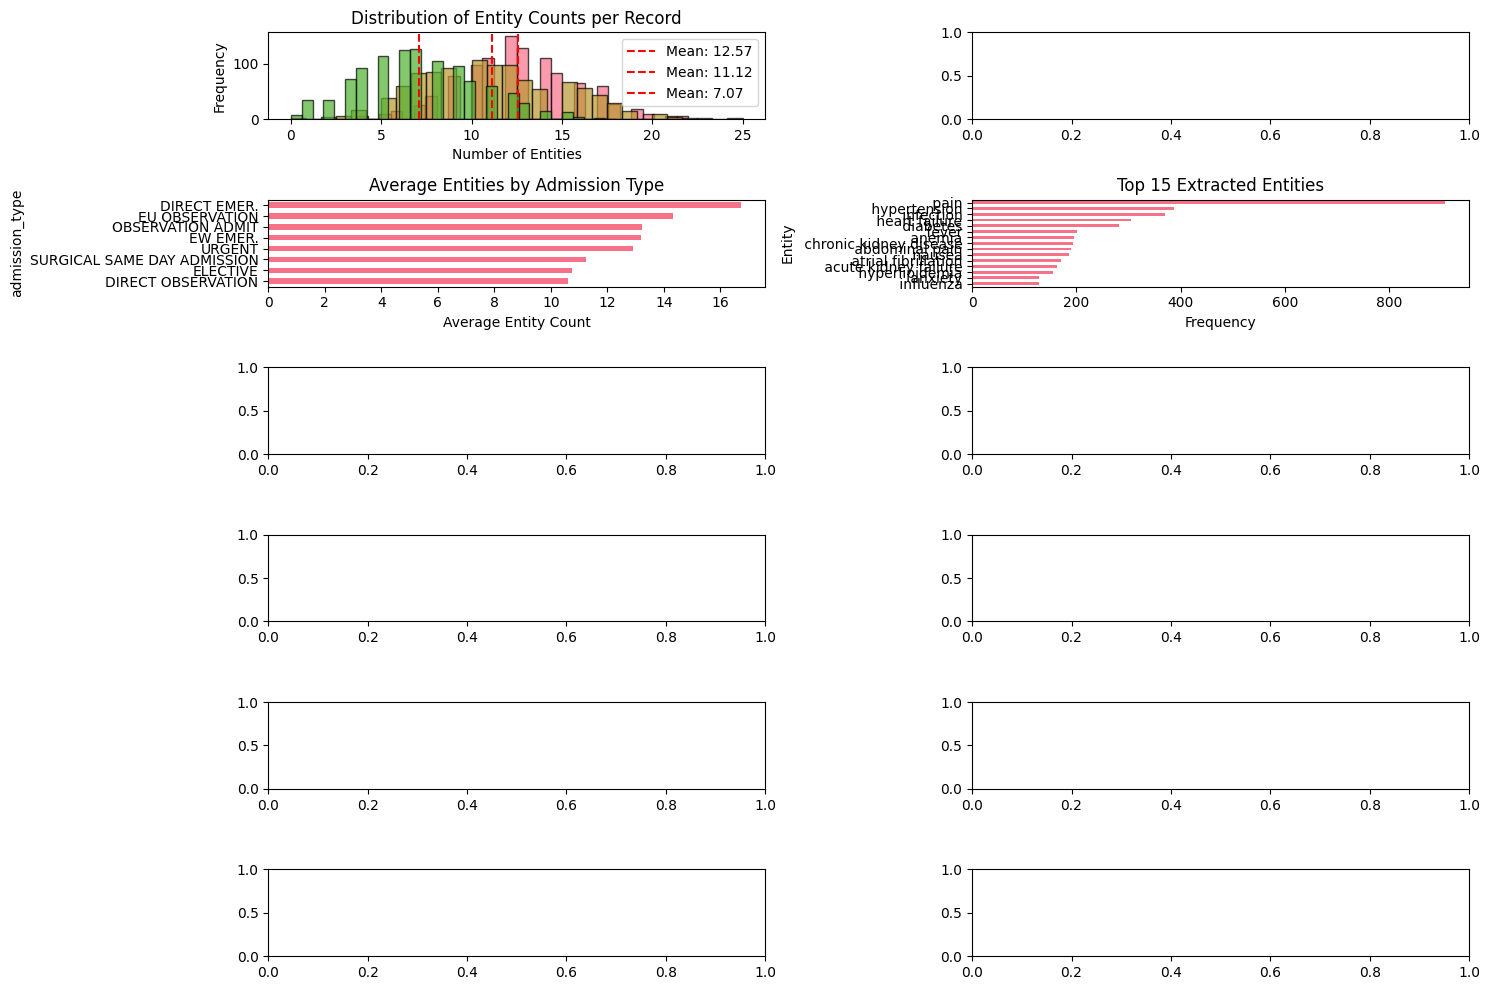

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [63]:
# Visualize NER results
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(6, 2, figsize=(15, 10))
sns.set_palette("husl")

for label in ['disease_entity_count', 'drug_entity_count', 'anatomy_entity_count']:
    # Entity count distribution
    axes[0, 0].hist(data_sample[label], bins=30, edgecolor='black', alpha=0.7)
    axes[0, 0].set_xlabel('Number of Entities')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('Distribution of Entity Counts per Record')
    axes[0, 0].axvline(data_sample[label].mean(), color='red', linestyle='--', 
                    label=f"Mean: {data_sample[label].mean():.2f}")
    axes[0, 0].legend()

# Disease vs Chemical counts
# axes[0, 1].scatter(data_sample['disease_count'], alpha=0.5)
# axes[0, 1].set_xlabel('Disease Entity Count')
# axes[0, 1].set_ylabel('Chemical Entity Count')
# axes[0, 1].set_title('Disease vs Chemical Entities')

    # Entity count by admission type
    if 'admission_type' in data_sample.columns:
        admission_entity_stats = data_sample.groupby('admission_type')[label].mean().sort_values()
        admission_entity_stats.plot(kind='barh', ax=axes[1, 0])
        axes[1, 0].set_xlabel('Average Entity Count')
        axes[1, 0].set_title('Average Entities by Admission Type')

# Top extracted entities  
for ent_type in ['disease_entities', 'drug_entities', 'anatomy_entities']:
    all_entities = []
    for entities_list in data_sample[ent_type]:
        all_entities.extend([ent['word'].lower() for ent in entities_list])

    if len(all_entities) > 0:
        from collections import Counter
        entity_counts = Counter(all_entities)
        top_entities = pd.DataFrame(entity_counts.most_common(15), 
                                    columns=['Entity', 'Count'])
        top_entities.plot(x='Entity', y='Count', kind='barh', ax=axes[1, 1], legend=False)
        axes[1, 1].set_xlabel('Frequency')
        axes[1, 1].set_title('Top 15 Extracted Entities')
        axes[1, 1].invert_yaxis()

    plt.tight_layout()
    plt.show()



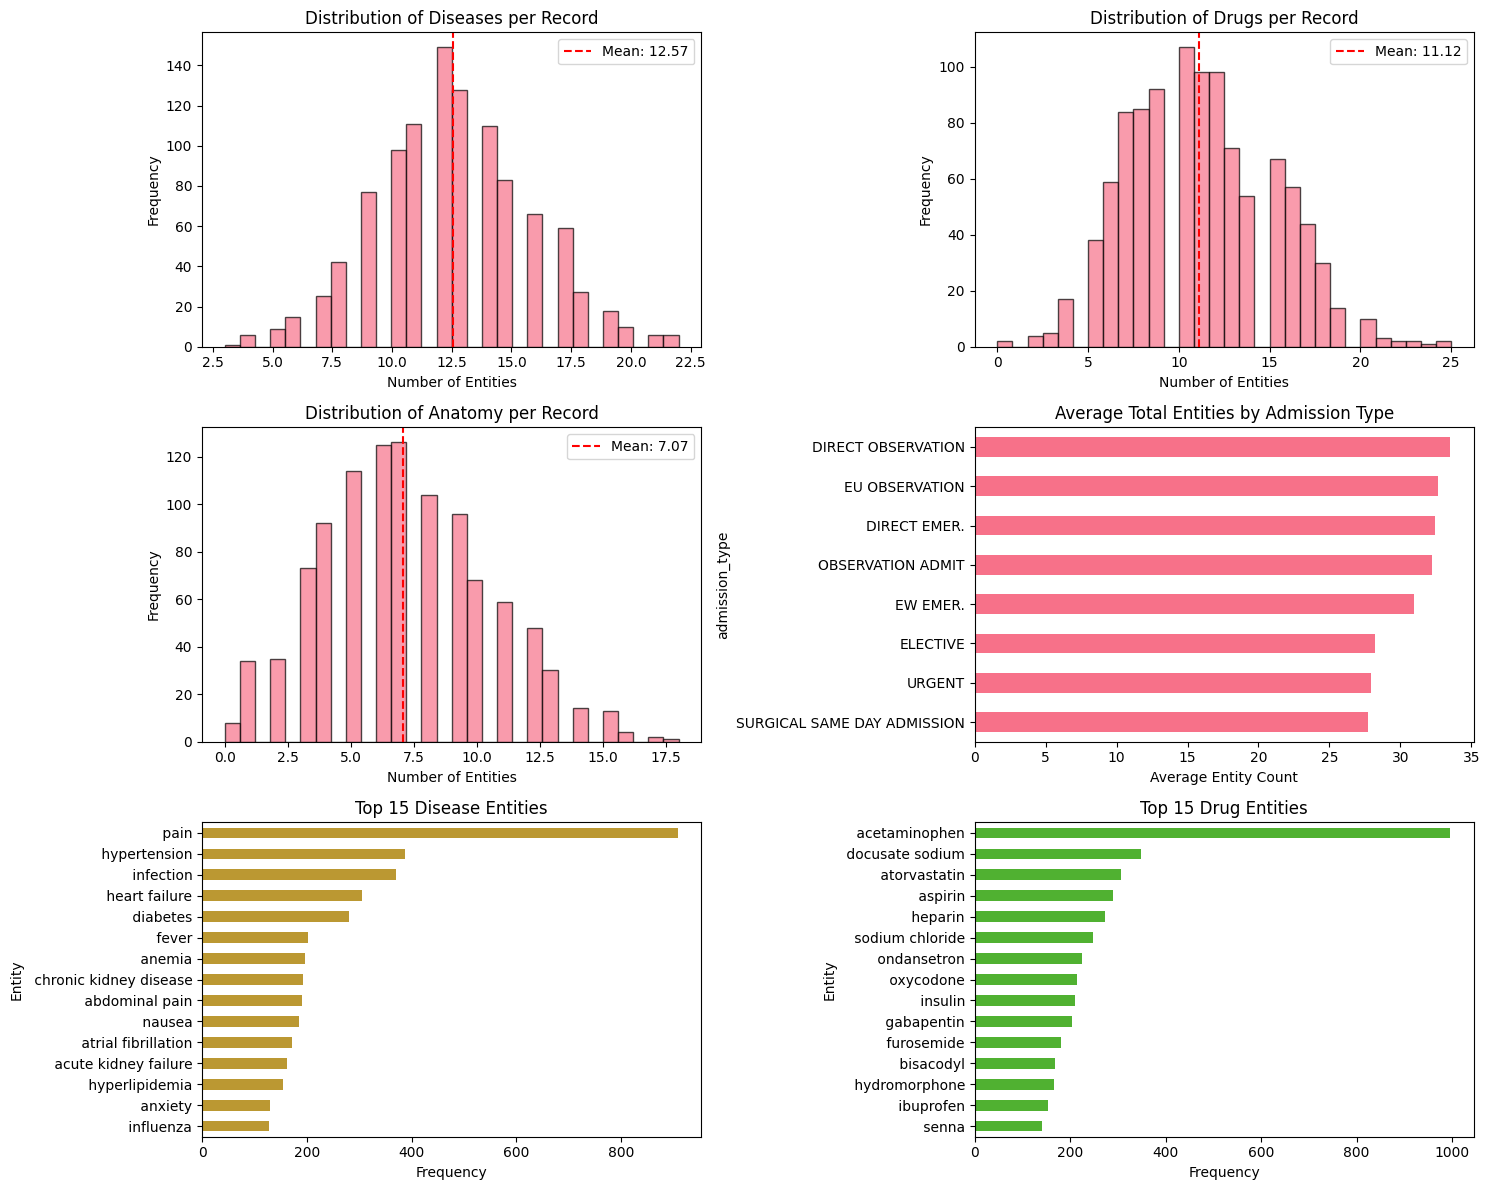

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Require `data_sample` to be defined (created earlier in the notebook)
if 'data_sample' not in globals():
    raise AssertionError("Define `data_sample` DataFrame before running this cell.")

# Fixed visualization: separate subplots, correct indexing, single show at end
labels = ['disease_entity_count', 'drug_entity_count', 'anatomy_entity_count']
label_titles = {
    'disease_entity_count': 'Diseases',
    'drug_entity_count': 'Drugs',
    'anatomy_entity_count': 'Anatomy',
}

fig, axes = plt.subplots(3, 2, figsize=(15, 12))
sns.set_palette("husl")

# Histograms per entity type
ax_map = {
    'disease_entity_count': axes[0, 0],
    'drug_entity_count': axes[0, 1],
    'anatomy_entity_count': axes[1, 0],
}

for label, ax in ax_map.items():
    if label in data_sample.columns:
        values = data_sample[label].dropna()
        ax.hist(values, bins=30, edgecolor='black', alpha=0.7)
        mean_val = values.mean() if len(values) else 0
        ax.axvline(mean_val, color='red', linestyle='--', label=f"Mean: {mean_val:.2f}")
        ax.set_xlabel('Number of Entities')
        ax.set_ylabel('Frequency')
        ax.set_title(f"Distribution of {label_titles[label]} per Record")
        ax.legend()
    else:
        ax.text(0.5, 0.5, f"Missing column: {label}", ha='center', va='center')
        ax.axis('off')

# Average total entities by admission type (sum across available entity counts)
if 'admission_type' in data_sample.columns:
    count_cols_present = [c for c in labels if c in data_sample.columns]
    if count_cols_present:
        tmp = data_sample.copy()
        tmp['total_entities'] = tmp[count_cols_present].sum(axis=1)
        admission_entity_stats = (
            tmp.groupby('admission_type')['total_entities']
               .mean()
               .sort_values()
        )
        admission_entity_stats.plot(kind='barh', ax=axes[1, 1], color=sns.color_palette()[0])
        axes[1, 1].set_xlabel('Average Entity Count')
        axes[1, 1].set_title('Average Total Entities by Admission Type')
    else:
        axes[1, 1].text(0.5, 0.5, "No entity count columns found", ha='center', va='center')
        axes[1, 1].axis('off')
else:
    axes[1, 1].text(0.5, 0.5, "Missing column: admission_type", ha='center', va='center')
    axes[1, 1].axis('off')

# Helper to compute top entities from list-of-dicts
from collections import Counter

def extract_top_entities(series_of_lists, top_k=15):
    all_entities = []
    for entities_list in series_of_lists:
        if isinstance(entities_list, list):
            for ent in entities_list:
                word = ent.get('word') if isinstance(ent, dict) else None
                if isinstance(word, str) and word.strip():
                    all_entities.append(word.lower())
    if not all_entities:
        return pd.DataFrame(columns=['Entity', 'Count'])
    entity_counts = Counter(all_entities)
    top_entities = pd.DataFrame(entity_counts.most_common(top_k), columns=['Entity', 'Count'])
    return top_entities

# Top entities for diseases and drugs
series_diseases = data_sample['disease_entities'] if 'disease_entities' in data_sample.columns else []
series_drugs = data_sample['drug_entities'] if 'drug_entities' in data_sample.columns else []

top_diseases = extract_top_entities(series_diseases)
top_drugs = extract_top_entities(series_drugs)

if not top_diseases.empty:
    top_diseases.plot(x='Entity', y='Count', kind='barh', ax=axes[2, 0], legend=False, color=sns.color_palette()[1])
    axes[2, 0].set_xlabel('Frequency')
    axes[2, 0].set_title('Top 15 Disease Entities')
    axes[2, 0].invert_yaxis()
else:
    axes[2, 0].text(0.5, 0.5, "No disease entities found", ha='center', va='center')
    axes[2, 0].axis('off')

if not top_drugs.empty:
    top_drugs.plot(x='Entity', y='Count', kind='barh', ax=axes[2, 1], legend=False, color=sns.color_palette()[2])
    axes[2, 1].set_xlabel('Frequency')
    axes[2, 1].set_title('Top 15 Drug Entities')
    axes[2, 1].invert_yaxis()
else:
    axes[2, 1].text(0.5, 0.5, "No drug entities found", ha='center', va='center')
    axes[2, 1].axis('off')

plt.tight_layout()
plt.show()
